# Feature Selection and Dataset Filtering Using RF

In [24]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

# Load the data
data = pd.read_csv('Ligand_All_Descriptors_only14_onlyL-0930-2.csv')

# Data preprocessing: Features are descriptors, removing 'No' and 'yield20'
X = data.drop(columns=['No', 'yield20'])  # 'No' is likely an index, and 'yield20' is the target variable
y = data['yield20']  # Target variable is 'yield20'

# Standardize the feature data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Use Random Forest to select the top 50 most important features
forest = RandomForestClassifier(n_estimators=100, random_state=42)
forest.fit(X_scaled, y)

# Get feature importances
importances = forest.feature_importances_

# Pair feature names with their importance scores
feature_importances = pd.DataFrame({'feature': X.columns, 'importance': importances})

# Sort by importance and select the top 50 features
top_50_features = feature_importances.sort_values(by='importance', ascending=False).head(50)['feature'].values

# Retain these 50 features from the original dataset
X_top_50 = data[top_50_features]

# Add back 'No' (identifier) and 'yield20' (target variable) columns
filtered_data = pd.concat([data[['No', 'yield20']], X_top_50], axis=1)

# Save the filtered dataset
filtered_data.to_csv('Filtered_Ligand_Descriptors.csv', index=False)

print("Filtered dataset with top 50 descriptors has been saved to 'Filtered_Ligand_Descriptors.csv'.")


Filtered dataset with top 50 descriptors has been saved to 'Filtered_Ligand_Descriptors.csv'.


# Optional: Recursive Feature Elimination (RFE)

In [37]:
import pandas as pd
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

# Load the data
data = pd.read_csv('Ligand_Descriptors.csv')

# Data preprocessing: Features are descriptors, removing 'ID' and 'yield20'
X = data.drop(columns=['ID', 'yield20'])  # 'ID' is likely an identifier, and 'yield20' is the target variable
y = data['yield20']  # Target variable is 'yield20'

# Standardize the feature data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Use Random Forest for Recursive Feature Elimination (RFE) to select the top 50 most important features
estimator = RandomForestClassifier(n_estimators=100, random_state=42)
selector = RFE(estimator, n_features_to_select=50, step=1)  # Selecting 50 features
selector = selector.fit(X_scaled, y)

# Get the names of the retained features
selected_features = X.columns[selector.support_]

# Retain these selected features from the original dataset
X_top_50 = data[selected_features]

# Add back 'ID' (identifier) and 'yield20' (target variable) columns
filtered_data = pd.concat([data[['ID', 'yield20']], X_top_50], axis=1)

# Save the filtered dataset
filtered_data.to_csv('Filtered_Ligand_Descriptors.csv', index=False)

print("Filtered dataset with top 50 descriptors has been saved to 'Filtered_Ligand_Descriptors.csv'.")


Filtered dataset with top 50 descriptors has been saved to 'Filtered_Ligand_Descriptors.csv'.


# Feature Selection, Polynomial Interaction, and Dataset Filtering

In [10]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.feature_selection import SelectFromModel

# Load the data
data = pd.read_csv('Ligand_Descriptors.csv')

# Data preprocessing: Features are descriptors, removing 'ID' and 'yield20'
X = data.drop(columns=['ID', 'yield20'])  # 'ID' is likely an identifier, and 'yield20' is the target variable
y = data['yield20']  # Target variable is 'yield20'

# Standardize the feature data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Use Random Forest to select important features
forest = RandomForestClassifier(n_estimators=100, random_state=42)
forest.fit(X_scaled, y)

# Select features based on importance
model = SelectFromModel(forest, prefit=True, threshold="median")
X_selected = model.transform(X_scaled)

# Use polynomial interaction terms for feature combinations
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_poly = poly.fit_transform(X_selected)

# Re-standardize the combined features
X_poly_scaled = scaler.fit_transform(X_poly)

# Convert the combined features to a DataFrame and keep the top 50 features
X_poly_df = pd.DataFrame(X_poly_scaled, columns=[f"poly_feature_{i}" for i in range(X_poly_scaled.shape[1])])

# If the number of combined features is greater than 50, retain only the top 50 features
X_top_50 = X_poly_df.iloc[:, :50]

# Add back the 'ID' and 'yield20' columns
filtered_data = pd.concat([data[['ID', 'yield20']], X_top_50], axis=1)

# Save the filtered dataset
filtered_data.to_csv('Filtered_Ligand_Descriptors.csv', index=False)

print("Filtered dataset with top 50 descriptors (including feature interactions) has been saved to 'Filtered_Ligand_Descriptors.csv'.")


Filtered dataset with top 50 descriptors (including feature interactions) has been saved to 'Filtered_Ligand_Descriptors.csv'.


# Classification Model Comparison with Top 50 Selected Features

In [3]:
import pandas as pd
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.gaussian_process import GaussianProcessClassifier

# Load the filtered dataset
data = pd.read_csv('Filtered_Ligand_Descriptors.csv')

# Data preprocessing: Features are descriptors, removing 'No' and 'yield20'
X = data.drop(columns=['No', 'yield20'])  # 'No' is likely an identifier, and 'yield20' is the target variable
y = data['yield20']  # Target variable is 'yield20'

# Standardize the feature data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Define various classification models to compare
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(),
    "SVM": SVC(),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "Naive Bayes": GaussianNB(),
    "MLP": MLPClassifier(max_iter=5000),
    "gbdt": GradientBoostingClassifier(),
    "extra_trees": ExtraTreesClassifier(),
    "adaboost": AdaBoostClassifier(),
    "LSVC": LinearSVC(),
    "XGBoost": XGBClassifier(),
    "LGBM": LGBMClassifier(),
    "CatBoost": CatBoostClassifier(),
    "GPC": GaussianProcessClassifier()
}

# Define 5-fold cross-validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define evaluation metrics
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score)
}

# Train and evaluate each model using cross-validation
results = {}

for model_name, model in models.items():
    scores = {}
    for metric_name, metric_scorer in scoring.items():
        # Perform cross-validation for each metric
        cv_scores = cross_val_score(model, X_scaled, y, cv=kf, scoring=metric_scorer)
        scores[metric_name] = cv_scores.mean()  # Store the average score
    results[model_name] = scores

# Convert the results into a DataFrame for display
results_df = pd.DataFrame(results).T

# Print the results of the model comparison
print("Classification Model Comparison with Top 50 Features:")
print(results_df)

# Save the results to a CSV file if desired
results_df.to_csv('model_comparison_results_top_50.csv', index=True)
print("Results saved to 'model_comparison_results_top_50.csv'.")


d:\Anaconda3\envs\deepchem\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
d:\Anaconda3\envs\deepchem\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
d:\Anaconda3\envs\deepchem\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
d:\Anaconda3\envs\deepchem\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
d:\Anaconda3\envs\deepchem\lib\site-packages\sklearn

[LightGBM] [Info] Number of positive: 39, number of negative: 53
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000050 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1414
[LightGBM] [Info] Number of data points in the train set: 92, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.423913 -> initscore=-0.306730
[LightGBM] [Info] Start training from score -0.306730
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

# Feature Selection with Random Forest

In [25]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
import numpy as np

# Load the data
data = pd.read_csv('Filtered_Ligand_Descriptors.csv')

# Data preprocessing: Features are descriptors, removing 'No' and 'yield20'
X = data.drop(columns=['No', 'yield20'])  # 'No' is likely an identifier, and 'yield20' is the target variable
y = data['yield20']  # Target variable is 'yield20'

# Standardize the feature data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Use Random Forest to select important features
forest = RandomForestClassifier(n_estimators=100, random_state=42)
forest.fit(X_scaled, y)

# Get feature importances
importances = forest.feature_importances_

# Pair feature names with their importance scores
feature_importances = pd.DataFrame({'feature': X.columns, 'importance': importances})

# Sort features by importance
sorted_features = feature_importances.sort_values(by='importance', ascending=False)['feature'].values

# Initialize the model (RandomForestClassifier can be replaced with others if needed)
log_reg = RandomForestClassifier()  # Can be replaced with LogisticRegression(), KNeighborsClassifier(), etc.

# Record best performance
best_score = -np.inf  # Track the best overall score
best_num_features = 0  # Track the number of features with the best performance
results = []  # Store results for different numbers of features

# Define evaluation metrics
scorers = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score)
}

# Test with 1 to 10 features
for num_features in range(1, 11):
    selected_features = sorted_features[:num_features]
    X_selected = data[selected_features]

    # Standardize the selected features
    X_selected_scaled = scaler.fit_transform(X_selected)

    # Calculate metrics
    scores = {
        'accuracy': np.mean(cross_val_score(log_reg, X_selected_scaled, y, cv=5, scoring=scorers['accuracy'])),
        'precision': np.mean(cross_val_score(log_reg, X_selected_scaled, y, cv=5, scoring=scorers['precision'])),
        'recall': np.mean(cross_val_score(log_reg, X_selected_scaled, y, cv=5, scoring=scorers['recall'])),
        'f1': np.mean(cross_val_score(log_reg, X_selected_scaled, y, cv=5, scoring=scorers['f1']))
    }

    # Print scores for the current number of features
    print(f"Number of features: {num_features}, "
          f"Accuracy: {scores['accuracy']:.4f}, "
          f"Precision: {scores['precision']:.4f}, "
          f"Recall: {scores['recall']:.4f}, "
          f"F1 Score: {scores['f1']:.4f}")

    # Record the results for this number of features
    results.append((num_features, scores['accuracy'], scores['precision'], scores['recall'], scores['f1']))

    # Select the best F1 score to determine the best number of features
    if scores['f1'] > best_score:
        best_score = scores['f1']
        best_num_features = num_features

# Output the best number of features and corresponding score
print(f"Best number of features: {best_num_features}, Best F1 score: {best_score:.4f}")

# Convert results to a DataFrame and display
results_df = pd.DataFrame(results, columns=['Number of Features', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])
print("Summary of results:", results_df)

# Retain the top features with the best number of features
top_features = sorted_features[:best_num_features]
X_top_best = data[top_features]

# Add back 'No' and 'yield20' columns
filtered_data = pd.concat([data[['No', 'yield20']], X_top_best], axis=1)

# Save the filtered dataset
filtered_data.to_csv('Filtered_Ligand_Descriptors_Best.csv', index=False)

print(f"Filtered dataset with top {best_num_features} descriptors has been saved to 'Filtered_Ligand_Descriptors_Best.csv'.")


Number of features: 1, Accuracy: 0.8609, Precision: 0.8628, Recall: 0.8289, F1 Score: 0.8302
Number of features: 2, Accuracy: 0.7739, Precision: 0.7572, Recall: 0.8067, F1 Score: 0.7569
Number of features: 3, Accuracy: 0.8087, Precision: 0.8225, Recall: 0.8067, F1 Score: 0.7858
Number of features: 4, Accuracy: 0.8435, Precision: 0.8585, Recall: 0.8067, F1 Score: 0.8035
Number of features: 5, Accuracy: 0.8522, Precision: 0.8585, Recall: 0.8067, F1 Score: 0.7939
Number of features: 6, Accuracy: 0.8522, Precision: 0.8486, Recall: 0.7844, F1 Score: 0.8194
Number of features: 7, Accuracy: 0.8348, Precision: 0.8258, Recall: 0.7622, F1 Score: 0.8137
Number of features: 8, Accuracy: 0.8261, Precision: 0.8423, Recall: 0.8044, F1 Score: 0.7891
Number of features: 9, Accuracy: 0.8435, Precision: 0.8238, Recall: 0.8467, F1 Score: 0.8294
Number of features: 10, Accuracy: 0.8522, Precision: 0.7905, Recall: 0.8467, F1 Score: 0.8215
Best number of features: 1, Best F1 score: 0.8302
Summary of results:

# Feature Selection with Logistic Regression Evaluation

In [27]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
import numpy as np

# Load the dataset
data = pd.read_csv('Filtered_Ligand_Descriptors.csv')

# Data preprocessing: Features are descriptors, removing 'No' and 'yield20'
X = data.drop(columns=['No', 'yield20'])  # 'No' is likely an identifier, and 'yield20' is the target variable
y = data['yield20']  # Target variable is 'yield20'

# Standardize the feature data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Use Random Forest to select important features
forest = RandomForestClassifier(n_estimators=100, random_state=42)
forest.fit(X_scaled, y)

# Get feature importances
importances = forest.feature_importances_

# Pair feature names with their importance scores
feature_importances = pd.DataFrame({'feature': X.columns, 'importance': importances})

# Sort features by importance
sorted_features = feature_importances.sort_values(by='importance', ascending=False)['feature'].values

# Initialize the model
log_reg = LogisticRegression(max_iter=1000)

# Record best performance
best_score = -np.inf  # Track the best overall score
best_num_features = 0  # Track the number of features with the best performance
results = []  # Store results for different numbers of features

# Define evaluation metrics
scorers = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score)
}

# Test with 1 to 10 features
for num_features in range(1, 11):
    selected_features = sorted_features[:num_features]
    X_selected = data[selected_features]

    # Standardize the selected features
    X_selected_scaled = scaler.fit_transform(X_selected)

    # Calculate metrics
    scores = {
        'accuracy': np.mean(cross_val_score(log_reg, X_selected_scaled, y, cv=5, scoring=scorers['accuracy'])),
        'precision': np.mean(cross_val_score(log_reg, X_selected_scaled, y, cv=5, scoring=scorers['precision'])),
        'recall': np.mean(cross_val_score(log_reg, X_selected_scaled, y, cv=5, scoring=scorers['recall'])),
        'f1': np.mean(cross_val_score(log_reg, X_selected_scaled, y, cv=5, scoring=scorers['f1']))
    }

    # Print scores for the current number of features
    print(f"Number of features: {num_features}, "
          f"Accuracy: {scores['accuracy']:.4f}, "
          f"Precision: {scores['precision']:.4f}, "
          f"Recall: {scores['recall']:.4f}, "
          f"F1 Score: {scores['f1']:.4f}")

    # Record the results for this number of features
    results.append((num_features, scores['accuracy'], scores['precision'], scores['recall'], scores['f1']))

    # Select the best F1 score to determine the best number of features
    if scores['f1'] > best_score:
        best_score = scores['f1']
        best_num_features = num_features

# Output the best number of features and corresponding score
print(f"Best number of features: {best_num_features}, Best F1 score: {best_score:.4f}")

# Convert results to a DataFrame and display
results_df = pd.DataFrame(results, columns=['Number of Features', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])
print("Summary of results:", results_df)

# Retain the top features with the best number of features
top_features = sorted_features[:best_num_features]
X_top_best = data[top_features]

# Add back 'No' and 'yield20' columns
filtered_data = pd.concat([data[['No', 'yield20']], X_top_best], axis=1)

# Save the filtered dataset
filtered_data.to_csv('Filtered_Ligand_Descriptors_Best.csv', index=False)

print(f"Filtered dataset with top {best_num_features} descriptors has been saved to 'Filtered_Ligand_Descriptors_Best.csv'.")


Number of features: 1, Accuracy: 0.8783, Precision: 0.8677, Recall: 0.8444, F1 Score: 0.8416
Number of features: 2, Accuracy: 0.8696, Precision: 0.8429, Recall: 0.8667, F1 Score: 0.8467
Number of features: 3, Accuracy: 0.8696, Precision: 0.8429, Recall: 0.8667, F1 Score: 0.8467
Number of features: 4, Accuracy: 0.8696, Precision: 0.8429, Recall: 0.8667, F1 Score: 0.8467
Number of features: 5, Accuracy: 0.8522, Precision: 0.8362, Recall: 0.8467, F1 Score: 0.8311
Number of features: 6, Accuracy: 0.8783, Precision: 0.8933, Recall: 0.8667, F1 Score: 0.8595
Number of features: 7, Accuracy: 0.8957, Precision: 0.9077, Recall: 0.8667, F1 Score: 0.8701
Number of features: 8, Accuracy: 0.8870, Precision: 0.9077, Recall: 0.8467, F1 Score: 0.8596
Number of features: 9, Accuracy: 0.8957, Precision: 0.9077, Recall: 0.8667, F1 Score: 0.8701
Number of features: 10, Accuracy: 0.8957, Precision: 0.9077, Recall: 0.8667, F1 Score: 0.8701
Best number of features: 7, Best F1 score: 0.8701
Summary of results:

In [31]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report

# Load the CSV file
data = pd.read_csv('Filtered_Ligand_Descriptors_Best.csv')

# Data preprocessing: features are descriptors, remove 'No' and 'yield20'
X = data.drop(columns=['No', 'yield20'])
y = data['yield20']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize the feature data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train a Logistic Regression  classifier
knn = LogisticRegression(max_iter=1000)  
knn.fit(X_train_scaled, y_train)

# Predict and evaluate
y_pred = knn.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')
print(classification_report(y_test, y_pred))


Accuracy: 0.9143
              precision    recall  f1-score   support

           0       0.90      0.95      0.92        19
           1       0.93      0.88      0.90        16

    accuracy                           0.91        35
   macro avg       0.92      0.91      0.91        35
weighted avg       0.92      0.91      0.91        35



# Calculate the confusion matrix

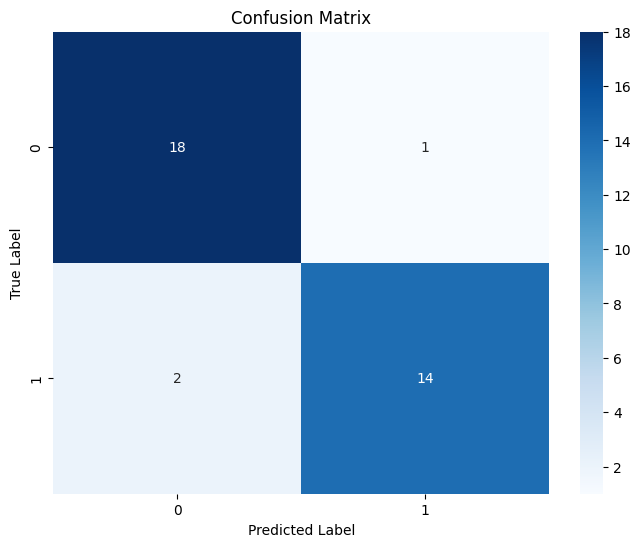

In [32]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Visual confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


# Five-fold cross-validation and dimensionality reduction

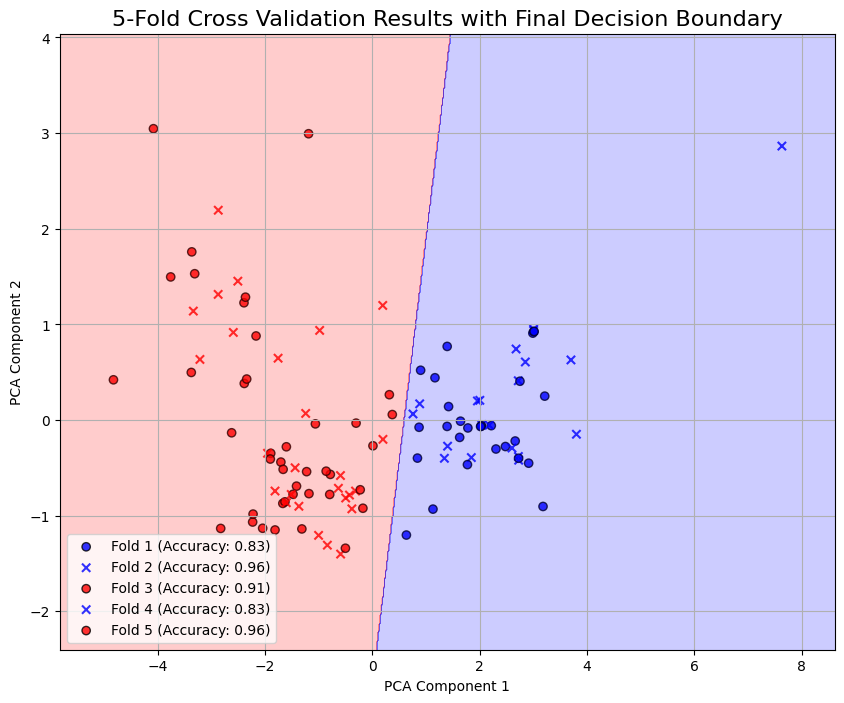

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from matplotlib.colors import ListedColormap

# Load the dataset
data = pd.read_csv('Filtered_Ligand_Descriptors_Best.csv')

# Data preprocessing: Features and target classification
X = data.drop(columns=['No', 'yield20'])  # Features
y = data['yield20']  # Target classification

# Standardize the feature data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA to reduce from 4 dimensions to 2 dimensions
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Define classifier
classifier = LogisticRegression(max_iter=1000)

# 5-fold cross-validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Set up the mesh grid for decision boundary plotting
x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                     np.arange(y_min, y_max, 0.02))

# Set colors and markers
colors = ['red', 'blue']
markers = ['o', 'x']
cmap = ListedColormap(colors)

# Initialize plot
plt.figure(figsize=(10, 8))

# Iterate over each fold in cross-validation
for fold_idx, (train_idx, test_idx) in enumerate(kf.split(X_pca, y)):
    X_train, X_test = X_pca[train_idx], X_pca[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # Train the model
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)

    # Choose whether to pass edgecolor based on marker type
    marker = markers[fold_idx % len(markers)]
    if marker == 'x':  # Avoid passing edgecolor for 'x' marker
        plt.scatter(X_test[:, 0], X_test[:, 1], 
                    c=y_pred, 
                    marker=marker, 
                    label=f'Fold {fold_idx+1} (Accuracy: {classifier.score(X_test, y_test):.2f})',
                    alpha=0.8, 
                    cmap=cmap)
    else:
        plt.scatter(X_test[:, 0], X_test[:, 1], 
                    c=y_pred, 
                    marker=marker, 
                    edgecolor='k',  # Use edgecolor for other markers
                    label=f'Fold {fold_idx+1} (Accuracy: {classifier.score(X_test, y_test):.2f})',
                    alpha=0.8, 
                    cmap=cmap)

# Train on the entire dataset and plot decision boundary
classifier.fit(X_pca, y)

# Plot final decision boundary
Z = classifier.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Draw classification boundary
plt.contourf(xx, yy, Z, alpha=0.2, cmap=cmap)

# Add legend and title
plt.title('5-Fold Cross Validation Results with Final Decision Boundary', fontsize=16)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(loc='best')
plt.grid(True)
plt.show()


# Logistic Regression Classification with PCA and Decision Boundary Visualization

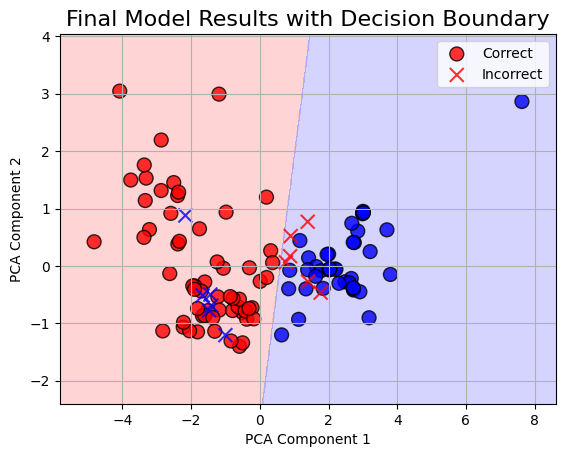

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from matplotlib.colors import ListedColormap

# Read data
data = pd.read_csv('Filtered_Ligand_Descriptors_Best.csv')

# Data preprocessing
X = data.drop(columns=['No', 'yield20'])  # Features
y = data['yield20']  # Target labels

# Standardize the feature data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Use PCA to reduce the 4-dimensional features to 2 dimensions
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Define classifier
classifier = LogisticRegression(max_iter=1000)

# Train the model on the entire dataset
classifier.fit(X_pca, y)

# Predict results
y_pred = classifier.predict(X_pca)

# Set up the grid for displaying decision boundaries
x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                     np.arange(y_min, y_max, 0.02))

# Plot decision boundaries
Z = classifier.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Set color maps
cmap_background = ListedColormap(['#FFAAAA', '#AAAAFF'])
cmap_points = ListedColormap(['#FF0000', '#0000FF'])

# Plot background classification regions
plt.contourf(xx, yy, Z, alpha=0.5, cmap=cmap_background)

# Identify correctly and incorrectly classified data
correct = y_pred == y
incorrect = ~correct

# Plot correctly classified data with solid circles
plt.scatter(X_pca[correct, 0], X_pca[correct, 1], 
            c=y[correct], cmap=cmap_points, 
            marker='o', edgecolor='k', s=100, alpha=0.8, label='Correct')

# Plot incorrectly classified data with 'x' markers
plt.scatter(X_pca[incorrect, 0], X_pca[incorrect, 1], 
            c=y[incorrect], cmap=cmap_points, 
            marker='x', s=100, alpha=0.8, label='Incorrect')

# Legend and title
plt.title('Final Model Results with Decision Boundary', fontsize=16)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(loc='best')
plt.grid(True)
plt.show()


Logistic Regression Classification with t-SNE Visualization

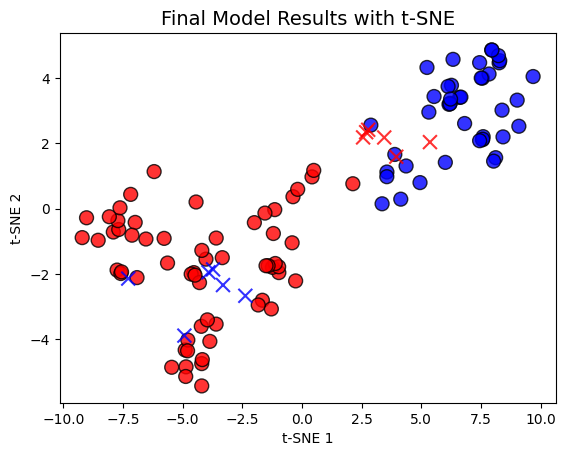

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from matplotlib.colors import ListedColormap

# Read data
data = pd.read_csv('Filtered_Ligand_Descriptors_Best.csv')

# Data preprocessing
X = data.drop(columns=['No', 'yield20'])  # Features
y = data['yield20']  # Target labels

# Standardize the feature data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Define classifier, using original 4-dimensional features
classifier = LogisticRegression(max_iter=1000)

# Train the model (using original 4-dimensional features)
classifier.fit(X_scaled, y)

# Predict results (using original 4-dimensional features)
y_pred = classifier.predict(X_scaled)

# Use t-SNE to reduce the 4-dimensional features to 2 dimensions for visualization only
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

# Set color maps
cmap_points = ListedColormap(['#FF0000', '#0000FF'])

# Identify correctly and incorrectly classified data
correct = y_pred == y
incorrect = ~correct

# Plot correctly classified data with solid circles
plt.scatter(X_tsne[correct, 0], X_tsne[correct, 1], 
            c=y[correct], cmap=cmap_points, 
            marker='o', edgecolor='k', s=100, alpha=0.8, label='Correct')

# Plot incorrectly classified data with 'x' markers
plt.scatter(X_tsne[incorrect, 0], X_tsne[incorrect, 1], 
            c=y[incorrect], cmap=cmap_points, 
            marker='x', s=100, alpha=0.8, label='Incorrect')

# Legend and title
plt.title('Final Model Results with t-SNE', fontsize=14)
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
#plt.legend(loc='best')
#plt.grid(True)
plt.show()


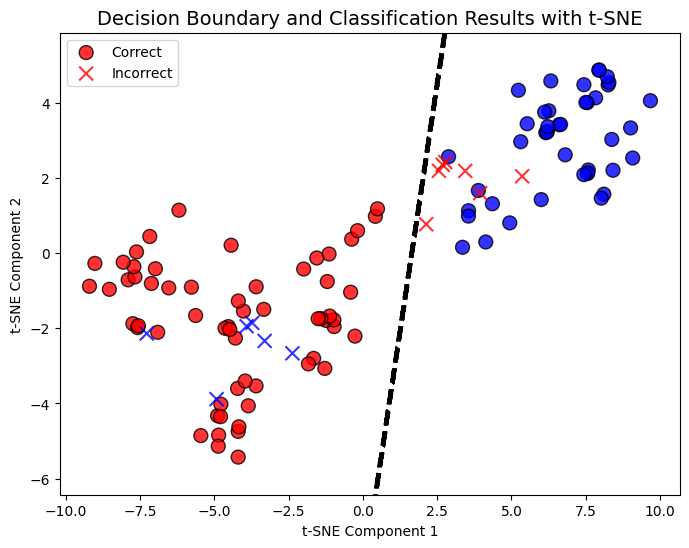

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from matplotlib.colors import ListedColormap

# Read data
data = pd.read_csv('Filtered_Ligand_Descriptors_Best.csv')

# Data preprocessing
X = data.drop(columns=['No', 'yield20'])  # Features
y = data['yield20']  # Target labels

# Standardize the feature data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Use t-SNE to reduce the data to 2 dimensions
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

# Retrain the classifier on t-SNE reduced features
classifier_2d = LogisticRegression(max_iter=1000)
classifier_2d.fit(X_tsne, y)

# Predict results
y_pred = classifier_2d.predict(X_tsne)

# Plot decision boundaries
h = .02  # Step size for the grid
x_min, x_max = X_tsne[:, 0].min() - 1, X_tsne[:, 0].max() + 1
y_min, y_max = X_tsne[:, 1].min() - 1, X_tsne[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# Predict using the trained model
Z = classifier_2d.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Set color maps
cmap_points = ListedColormap(['#FF0000', '#0000FF'])

# Plot decision boundary as a thick dashed line
plt.figure(figsize=(8, 6))
plt.contour(xx, yy, Z, linestyles='--', linewidths=3, colors='k')

# Identify correctly and incorrectly classified data
correct = y_pred == y
incorrect = ~correct

# Plot correctly classified data with solid circles
plt.scatter(X_tsne[correct, 0], X_tsne[correct, 1], 
            c=y[correct], cmap=cmap_points, 
            marker='o', edgecolor='k', s=100, alpha=0.8, label='Correct')

# Plot incorrectly classified data with 'x' markers
plt.scatter(X_tsne[incorrect, 0], X_tsne[incorrect, 1], 
            c=y[incorrect], cmap=cmap_points, 
            marker='x', s=100, alpha=0.8, label='Incorrect')

# Legend and title
plt.title('Decision Boundary and Classification Results with t-SNE', fontsize=14)
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(loc='best')
plt.show()


# SHAP Analysis and Logistic Regression for Ligand Descriptors

Using 115 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
100%|██████████| 115/115 [00:07<00:00, 15.15it/s]


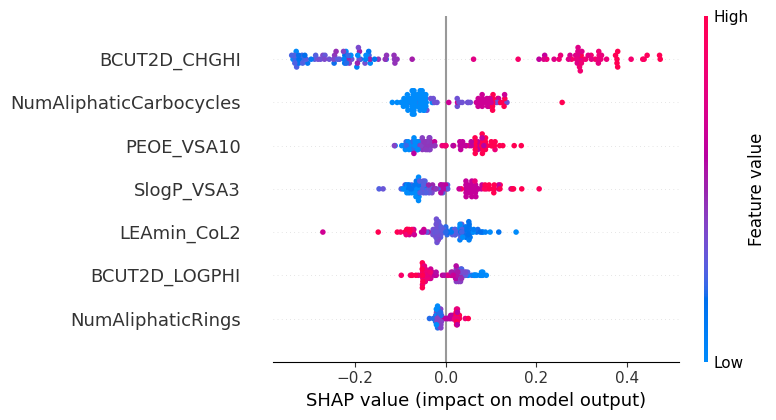

In [40]:
import pandas as pd
import shap
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

# Load data
data = pd.read_csv('Filtered_Ligand_Descriptors_Best.csv')

# Data preprocessing
X = data.drop(columns=['No', 'yield20'])  # Features
y = data['yield20']  # Target variable

# Standardize the feature data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Define and train the classifier
classifier = LogisticRegression(max_iter=1000)
classifier.fit(X_scaled, y)

# Create SHAP explainer using KernelExplainer
explainer = shap.KernelExplainer(classifier.predict, X_scaled)

# Calculate SHAP values
shap_values = explainer.shap_values(X_scaled)

# Plot SHAP summary plot (dot plot)
shap.summary_plot(shap_values, X_scaled, feature_names=X.columns, plot_type="dot", color_bar=True)


Using 115 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
100%|██████████| 115/115 [00:07<00:00, 15.24it/s]


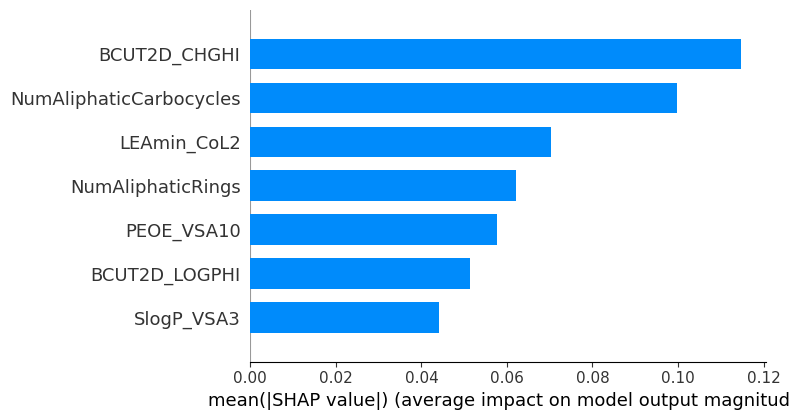

In [41]:
import pandas as pd
import shap
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler

# Load data
data = pd.read_csv('Filtered_Ligand_Descriptors_Best.csv')

# Data preprocessing
X = data.drop(columns=['No', 'yield20'])  # Features
y = data['yield20']  # Target variable

# Standardize the feature data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Define and train the classifier
classifier = GaussianNB()
classifier.fit(X_scaled, y)

# Create SHAP explainer using KernelExplainer
explainer = shap.KernelExplainer(classifier.predict, X_scaled)

# Calculate SHAP values
shap_values = explainer.shap_values(X_scaled)

# Plot feature importance bar chart
shap.summary_plot(shap_values, X_scaled, feature_names=X.columns, plot_type="bar")
